In [1]:
import pandas as pd

In [65]:
df = pd.read_csv('./data/second_innings.csv')
df

,match_id,venue,innings,ball,batting_team,bowling_team,runs_off_bat,extras,wides,noballs,byes,legbyes,wicket_type,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1001349,Melbourne Cricket Ground,2,0.6,Sri Lanka,Australia,0,0,NaN,NaN,NaN,NaN,caught,164.0,9.0,114.0,5.00,8.63,1.0
1,1001349,Melbourne Cricket Ground,2,8.5,Sri Lanka,Australia,0,0,NaN,NaN,NaN,NaN,caught,90.0,8.0,67.0,8.94,8.06,1.0
2,1001349,Melbourne Cricket Ground,2,10.4,Sri Lanka,Australia,0,0,NaN,NaN,NaN,NaN,caught,78.0,7.0,56.0,8.53,8.36,1.0
3,1001349,Melbourne Cricket Ground,2,17.1,Sri Lanka,Australia,0,0,NaN,NaN,NaN,NaN,stumped,18.0,6.0,17.0,8.80,6.35,1.0
4,1001349,Melbourne Cricket Ground,2,17.3,Sri Lanka,Australia,0,0,NaN,NaN,NaN,NaN,lbw,17.0,5.0,15.0,8.69,6.80,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243844,995469,R Premadasa Stadium,2,17.1,Australia,Sri Lanka,1,0,NaN,NaN,NaN,NaN,NaN,8.0,4.0,17.0,7.05,2.82,1.0
243845,995469,R Premadasa Stadium,2,17.2,Australia,Sri Lanka,3,0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,16.0,7.15,1.88,1.0
243846,995469,R Premadasa Stadium,2,17.3,Australia,Sri Lanka,0,0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,15.0,7.09,2.00,1.0
243847,995469,R Premadasa Stadium,2,17.4,Australia,Sri Lanka,0,0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,14.0,7.02,2.14,1.0


In [66]:
df.drop(columns=['venue', 'innings', 'ball', 'batting_team', 'bowling_team', 'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'wicket_type'], inplace=True)
df.head()

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1001349,164.0,9.0,114.0,5.00,8.63,1.0
1,1001349,90.0,8.0,67.0,8.94,8.06,1.0
2,1001349,78.0,7.0,56.0,8.53,8.36,1.0
3,1001349,18.0,6.0,17.0,8.80,6.35,1.0
4,1001349,17.0,5.0,15.0,8.69,6.80,1.0


In [67]:
df.isna().sum()

match_id                0
runs_required           0
wickets_remaining       0
balls_remaining         0
crr                     0
rrr                     0
winner               3701
dtype: int64

In [68]:
df.dropna(inplace=True)

In [69]:
df.isna().sum()

match_id             0
runs_required        0
wickets_remaining    0
balls_remaining      0
crr                  0
rrr                  0
winner               0
dtype: int64

In [70]:
df.shape

(240148, 7)

In [71]:
df['runs_required'] = df['runs_required'].astype('int')
df['wickets_remaining'] = df['wickets_remaining'].astype('int')
df['balls_remaining'] = df['balls_remaining'].astype('int')
df['winner'] = df['winner'].astype('int')

In [72]:
df.head()

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1001349,164,9,114,5.00,8.63,1
1,1001349,90,8,67,8.94,8.06,1
2,1001349,78,7,56,8.53,8.36,1
3,1001349,18,6,17,8.80,6.35,1
4,1001349,17,5,15,8.69,6.80,1


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

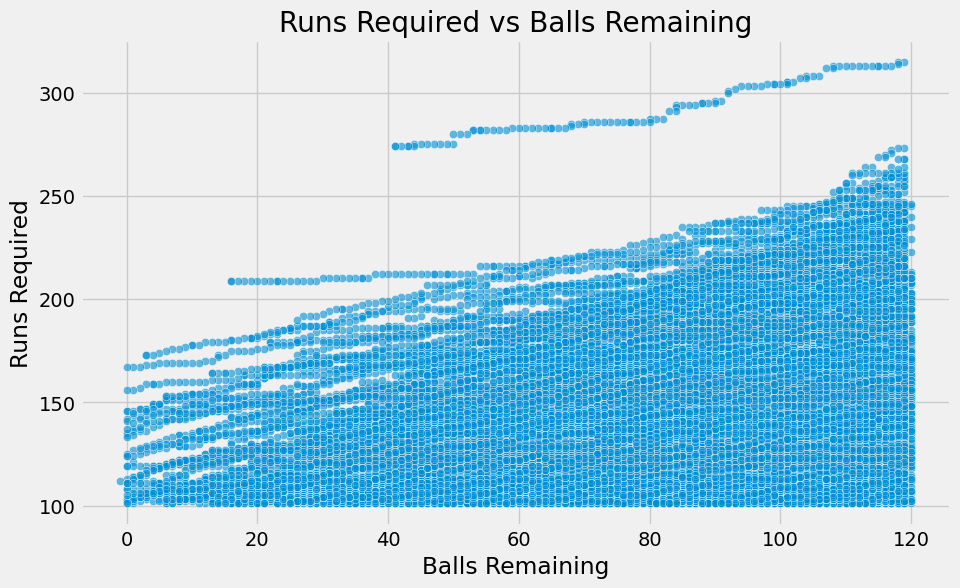

In [73]:
# scatter plot for runs required with minimum runs 100 vs balls remaining
plt.figure(figsize=(10, 6))
sns.scatterplot(x='balls_remaining', y='runs_required', data=df[(df['runs_required'] > 100)], alpha=0.6)
plt.title('Runs Required vs Balls Remaining')
plt.xlabel('Balls Remaining')
plt.ylabel('Runs Required')
plt.show()

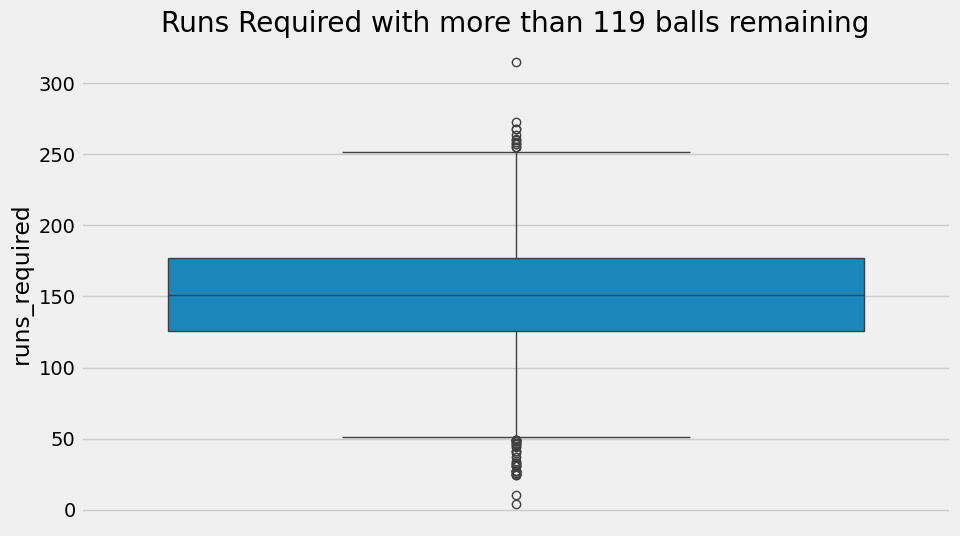

In [74]:
# boxplot for runs remaining with more than 119 balls remaining
plt.figure(figsize=(10, 6))
sns.boxplot(y='runs_required', data=df[(df['balls_remaining'] >= 119)])
plt.title('Runs Required with more than 119 balls remaining')
plt.show()

In [75]:
# get q1, q2, q3 for runs remaining with more than 119 balls remaining
q1 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.25)
q2 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.5)
q3 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 126.0, Q2: 151.0, Q3: 177.0
Lower Bound: 49.5, Upper Bound: 253.5


In [76]:
# find match_id for outliers accordingly
outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]

outlier_matches = outliers['match_id'].unique()

outlier_matches

C:\Users\Rushabh Javeri\AppData\Local\Temp\ipykernel_3108\3550993586.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]


array([1322001, 1373582, 1383101, 1122730, 1168113, 1176796, 1184901,
       1273723, 1283030, 1299577, 1307478, 1310177, 1320974, 1322003,
       1332506, 1339605, 1343749, 1343756, 1343760, 1343763, 1354803,
       1383103, 1399104, 1399119, 1400980, 1400988, 1403305, 1418541,
       1418543,  287860,  682933,  995467], dtype=int64)

In [77]:
df[df['match_id'].isin(outlier_matches)]

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
516,1122730,225,9,93,8.00,14.52,0
517,1122730,116,8,40,10.88,17.40,0
518,1122730,106,7,35,10.94,18.17,0
519,1122730,105,6,34,10.88,18.53,0
520,1122730,100,5,31,10.85,19.35,0
...,...,...,...,...,...,...,...
243734,995467,86,1,4,9.21,129.00,0
243735,995467,86,1,3,9.13,172.00,0
243736,995467,86,1,2,9.05,258.00,0
243737,995467,86,1,1,8.97,516.00,0


In [78]:
# drop where match id is in outlier_matches
df = df[~df['match_id'].isin(outlier_matches)]
df

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1001349,164,9,114,5.00,8.63,1
1,1001349,90,8,67,8.94,8.06,1
2,1001349,78,7,56,8.53,8.36,1
3,1001349,18,6,17,8.80,6.35,1
4,1001349,17,5,15,8.69,6.80,1
...,...,...,...,...,...,...,...
243844,995469,8,4,17,7.05,2.82,1
243845,995469,5,4,16,7.15,1.88,1
243846,995469,5,4,15,7.09,2.00,1
243847,995469,5,4,14,7.02,2.14,1


In [79]:
# preprocessing for model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['runs_required', 'wickets_remaining', 'crr', 'rrr', 'balls_remaining']]
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [80]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline

# pipe = Pipeline(steps=[('scaler', trf), ('model', LogisticRegression())])

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [81]:
accuracy = model.score(X_test, y_test)
accuracy

0.8288083989501313

In [82]:
X_test[10]

array([-0.33344287,  0.77863793,  0.1959168 , -0.24860295,  0.36364042])

In [83]:
model.predict_proba(X_test)[10]

array([0.08897956, 0.91102044])

In [87]:
# test for custom input
print(model.predict([[50, 5, 7, 6, 50]]))
print(model.predict_proba([[50, 5, 7, 6, 50]]))

[0]
[[1.00000000e+00 9.52625144e-52]]
